[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Piphi5/Adopt-a-Pixel3km-Notebooks/blob/main/CEO%20GO%20Join/GO_CEO_Join.ipynb)

# Setup

In [1]:
import sys

if "google.colab" in sys.modules:
    ! pip install -q condacolab
    import condacolab

    condacolab.install()
    ! wget https://raw.githubusercontent.com/Piphi5/Adopt-a-Pixel3km-Notebooks/main/CEO%20GO%20Join/environment.yml
    ! conda config --set channel_priority strict
    ! conda env update -n base -f environment.yml

In [2]:
import os

import requests

files = ["harmonization_utils", "plotting_utils"]

if "google.colab" in sys.modules:
    for file in files:
        url = f"https://raw.githubusercontent.com/Piphi5/Adopt-a-Pixel3km-Notebooks/main/utils/code/{file}.py"
        exec(requests.get(url).text)
else:
    module_path = os.path.abspath(os.path.join("../utils/code"))
    sys.path.append(module_path)
    from harmonization_utils import *
    from plotting_utils import *

from math import asin, cos, radians, sin, sqrt

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from geopandas.tools import sjoin
from go_utils import get_api_data

# Data Preparation

## Downloading CEO Data

- `filename`: The path containing the Primary Sampling Unit Data
- `output_directory`: The directory in which graphs and CSV's will be saved to
- `start_date`: The start date for the GLOBE Observer Data
- `end_date`: The end date for the GLOBE Observer Data

In [3]:
filename = "Sample Data/PSU Data.csv"
output_directory = "CEO GO Output"

start_date = "2021-06-01"
end_date = "2021-08-31"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)

In [4]:
ceo_df = pd.read_csv(filename)

In [5]:
ceo_df

,Unnamed: 0,plot_id,center_lon,center_lat,size_m,shape,sample_points,email,flagged,flagged_reason,...,Land Cover Elements:Water>treated pool,Land Cover Elements:Water>lake/ponded/container,Land Cover Elements:Water>rivers/stream,Land Cover Elements:Water>irrigation ditch,Land Cover Elements:shadow,Land Cover Elements:unknown,Land Cover Elements:Bare Ground,Land Cover Elements:Building,Land Cover Elements:Impervious Surface (no building),AOI Number
0,0,140877071,-89.568191,43.076827,square,100.0,100,52,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
1,2058,140879129,-96.732731,33.127087,square,100.0,100,66,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,66.0,55.0
2,2056,140879127,-96.743470,33.127087,square,100.0,100,66,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,31.0,55.0
3,2055,140879126,-96.748839,33.127087,square,100.0,100,66,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,34.0,55.0
4,2054,140879125,-96.754209,33.127087,square,100.0,100,66,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.0,33.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,704,140963199,-106.233694,31.717792,square,100.0,100,45,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,57.0,41.0,0.0,76.0
1994,734,140963229,-106.233694,31.695308,square,100.0,100,45,False,NaN,...,0.0,0.0,0.0,16.0,18.0,0.0,16.0,30.0,20.0,76.0
1995,716,140963211,-106.233694,31.708798,square,100.0,100,45,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,56.0,76.0
1996,719,140963214,-106.217837,31.708798,square,100.0,100,45,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,48.0,36.0,16.0,76.0


## Downloading GLOBE Observer Data

In [6]:
lc_df = get_api_data("land_covers", start_date=start_date, end_date=end_date)
lc_df

,lc_measuredDate,lc_createDate,lc_updateDate,lc_publishDate,lc_organizationId,lc_organizationName,lc_siteId,lc_siteName,lc_countryName,lc_countryCode,...,lc_SouthPrimary,lc_SouthSecondary,lc_WestPrimary,lc_WestSecondary,lc_PrimaryClassification,lc_SecondaryClassification,lc_PrimaryPercentage,lc_SecondaryPercentage,lc_SubCompletenessScore,lc_CumulativeCompletenessScore
0,2021-08-26,2021-08-26 09:15:04,2021-08-26 09:15:04,2021-12-10 21:00:01,8095781,The 2nd Secondary Girls School at Jazan,32857,The 2nd Secondary School at Jazan:ATM-01,Saudi Arabia,SAU,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.90
1,2021-06-11,2021-06-11 09:35:03,2021-06-11 09:35:03,2021-12-10 21:00:01,2567229,OS Ivana Kukuljevica,33050,"lipa- lime, Phenology Campaign",Croatia,HRV,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.0,0.90
2,2021-06-18,2021-06-18 16:15:03,2021-06-18 16:15:03,2021-12-10 21:00:01,3507942,South Dakota Discovery Center (Data Entry),35129,South Dakota Discovery Center Mayors' Grove,United States,USA,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.4,0.92
3,2021-07-13,2021-07-13 04:55:04,2021-12-05 01:55:08,2021-12-10 21:00:01,17043304,United States of America Citizen Science,35803,11SMT309761,United States,USA,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.2,0.93
4,2021-07-28,2021-07-28 14:30:04,2021-12-05 01:55:08,2021-12-10 21:00:01,17043304,United States of America Citizen Science,40974,13SCV566084,United States,USA,...,"Urban, Residential Property",NA,"Urban, Residential Property",NA,"Urban, Residential Property",NA,100.0,0.0,1.0,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,2021-08-27,2021-09-01 12:45:03,2021-12-05 01:55:08,2021-12-10 21:00:01,17272022,Australia Citizen Science,248414,53JLL322363,Australia,AUS,...,"Barren, Sandy","Barren, Dirt/Other","Barren, Sandy","Barren, Dirt/Other","Barren, Sandy","Barren, Dirt/Other",80.0,70.0,1.0,0.98
3837,2021-08-19,2021-09-01 19:30:03,2021-09-01 19:30:03,2021-12-10 21:00:01,32402168,"College of Earth, Ocean, Atmospheric Sciences ...",248448,10TFR058283,United States,USA,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.6,0.96
3838,2021-08-14,2021-09-04 11:05:04,2021-09-04 11:05:04,2021-12-10 21:00:01,82073738,DEMONSTRATION SCHOOL OF THAKSIN UNIVERSITY,248641,47NPJ025362,Thailand,THA,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.3,0.94
3839,2021-08-21,2021-09-14 20:10:17,2021-12-05 01:55:08,2021-12-10 21:00:01,17043304,United States of America Citizen Science,249718,13SCU468846,United States,USA,...,"Cultivated, Athletic Field, Golf Course, Cemetery",NA,"Cultivated, Athletic Field, Golf Course, Cemetery",NA,"Cultivated, Athletic Field, Golf Course, Cemetery",NA,100.0,0.0,1.0,0.98


## Join CEO and GO Data

`buffer_size`: The sidelength of the square buffer to merge the CEO and GLOBE data in meters. For example, the default 100m buffer creates a 100m square buffer (50m from the center).

In [7]:
buffer_size = 100

In [8]:
g_ceo_df = gpd.GeoDataFrame(
    ceo_df,
    geometry=gpd.points_from_xy(
        np.round(ceo_df["center_lon"], 4), np.round(ceo_df["center_lat"], 4)
    ),
    crs="EPSG:4326",
).to_crs(epsg=3395)
g_lc_df = gpd.GeoDataFrame(
    lc_df,
    geometry=gpd.points_from_xy(lc_df["lc_Longitude"], lc_df["lc_Latitude"]),
    crs="EPSG:4326",
)
g_ceo_df.geometry = g_ceo_df.buffer(buffer_size / 2, cap_style=3)
g_ceo_df = g_ceo_df.to_crs(epsg=4326)
joined_df = sjoin(g_ceo_df, g_lc_df, how="inner")
joined_df

C:\Users\piphi\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\piphi\AppData\Roaming\Python\Python37\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\piphi\anaconda3\envs\py3k\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326', 'no_defs': True} != EPSG

,Unnamed: 0,plot_id,center_lon,center_lat,size_m,shape,sample_points,email,flagged,flagged_reason,...,lc_SouthPrimary,lc_SouthSecondary,lc_WestPrimary,lc_WestSecondary,lc_PrimaryClassification,lc_SecondaryClassification,lc_PrimaryPercentage,lc_SecondaryPercentage,lc_SubCompletenessScore,lc_CumulativeCompletenessScore
31,2106,140879177,-97.776397,30.253758,square,100.0,100,67,False,NaN,...,"Urban, Residential Property","Herbaceous/Grassland, Short Grass, Urban, Road...","Urban, Residential Property","Herbaceous/Grassland, Short Grass","Urban, Residential Property","Herbaceous/Grassland, Short Grass",77.5,30.0,0.7,0.96
32,2086,140879157,-97.786809,30.267248,square,100.0,100,67,False,NaN,...,"Urban, Commercial Property","Trees, Closely Spaced, Evergreen - Broad Leave...","Urban, Commercial Property","Trees, Closely Spaced, Evergreen - Broad Leave...","Urban, Commercial Property","Trees, Closely Spaced, Evergreen - Broad Leave...",80.0,47.5,0.9,0.97
33,2084,140879155,-97.765985,30.271745,square,100.0,100,67,False,NaN,...,"Urban, Roads and Parking","Trees, Closely Spaced, Deciduous - Broad Leaved","Urban, Roads and Parking","Trees, Closely Spaced, Deciduous - Broad Leave...","Herbaceous/Grassland, Short Grass, Urban, Comm...","Cultivated, Athletic Field, Golf Course, Cemetery",50.0,40.0,1.0,0.98
34,2078,140879149,-97.765985,30.276242,square,100.0,100,67,False,NaN,...,"Urban, Roads and Parking, Urban, Commercial Pr...",NA,"Urban, Roads and Parking, Urban, Commercial Pr...",NA,"Urban, Commercial Property","Urban, Roads and Parking",100.0,90.0,1.0,0.98
52,1967,140879038,-80.829777,35.202228,square,100.0,100,65,False,NaN,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.6,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,704,140963199,-106.233694,31.717792,square,100.0,100,45,False,NaN,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.6,0.96
1994,734,140963229,-106.233694,31.695308,square,100.0,100,45,False,NaN,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.6,0.96
1995,716,140963211,-106.233694,31.708798,square,100.0,100,45,False,NaN,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.6,0.96
1996,719,140963214,-106.217837,31.708798,square,100.0,100,45,False,NaN,...,NA,NA,NA,NA,NA,NA,0.0,0.0,0.6,0.96


## Distance Statistics

Statistics on the distance between GLOBE and CEO observations

In [9]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees)

    From: https://stackoverflow.com/a/4913653
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r * 1000  # put into meters


vec_haversine = np.vectorize(haversine)
joined_df["Point Distance"] = vec_haversine(
    joined_df["center_lon"].to_numpy(),
    joined_df["center_lat"].to_numpy(),
    joined_df["lc_Longitude"].to_numpy(),
    joined_df["lc_Latitude"].to_numpy(),
)
joined_df["Point Distance"].describe()

count    635.000000
mean      20.262198
std       13.630795
min        0.000000
25%        7.754118
50%       20.889518
75%       31.069758
max       51.323338
Name: Point Distance, dtype: float64

## Column Harmonization

### Removing Excess GLOBE  Columns

In [10]:
joined_df = joined_df.drop(
    columns=[
        col for col in joined_df.columns if col.count("_") == 2 and "Overall" not in col
    ]
)

### Aggregate GLOBE and CEO columns

In [11]:
grass_cols = [
    col for col in joined_df.columns if col.count("_") == 2 and "Grass" in col
]

barren_cols = [
    col for col in joined_df.columns if col.count("_") == 2 and "Barren" in col
]

trees_cols = [
    col for col in joined_df.columns if col.count("_") == 2 and "Trees" in col
]

shrub_cols = [
    col for col in joined_df.columns if col.count("_") == 2 and "Shrub" in col
]

cultivated_cols = [
    col for col in joined_df.columns if col.count("_") == 2 and "Cultivated" in col
]

water_cols = [
    col for col in joined_df.columns if col.count("_") == 2 and "water" in col.lower()
]
urban_cols = [
    col for col in joined_df.columns if col.count("_") == 2 and "urban" in col.lower()
]


def sum_percentages(*args):
    return sum(args)


aggregate_lc_types = np.vectorize(sum_percentages)

In [12]:
joined_df["GO_Grass"] = aggregate_lc_types(
    *[joined_df[col].to_numpy() for col in grass_cols]
)
joined_df["GO_Barren"] = aggregate_lc_types(
    *[joined_df[col].to_numpy() for col in barren_cols]
)
joined_df["GO_Trees"] = aggregate_lc_types(
    *[joined_df[col].to_numpy() for col in trees_cols]
)
joined_df["GO_Shrub"] = aggregate_lc_types(
    *[joined_df[col].to_numpy() for col in shrub_cols]
)
joined_df["GO_Cultivated"] = aggregate_lc_types(
    *[joined_df[col].to_numpy() for col in cultivated_cols]
)
joined_df["GO_Water"] = aggregate_lc_types(
    *[joined_df[col].to_numpy() for col in water_cols]
)
joined_df["GO_BuiltUp"] = aggregate_lc_types(
    *[joined_df[col].to_numpy() for col in urban_cols]
)

ceo_harmonization(joined_df)

In [13]:
joined_df

,Unnamed: 0,plot_id,center_lon,center_lat,size_m,shape,sample_points,email,flagged,flagged_reason,...,GO_Cultivated,GO_Water,GO_BuiltUp,CEO_BuiltUp,CEO_Trees,CEO_Shrubland,CEO_Grassland,CEO_Cropland,CEO_Water,CEO_Barren
31,2106,140879177,-97.776397,30.253758,square,100.0,100,67,False,NaN,...,0,0,99,36.0,50.0,0.0,4.0,0.0,0.0,10.0
32,2086,140879157,-97.786809,30.267248,square,100.0,100,67,False,NaN,...,0,0,107,39.0,48.0,0.0,13.0,0.0,0.0,0.0
33,2084,140879155,-97.765985,30.271745,square,100.0,100,67,False,NaN,...,40,0,75,34.0,3.0,0.0,55.0,0.0,0.0,8.0
34,2078,140879149,-97.765985,30.276242,square,100.0,100,67,False,NaN,...,0,0,190,84.0,10.0,0.0,6.0,0.0,0.0,0.0
52,1967,140879038,-80.829777,35.202228,square,100.0,100,65,False,NaN,...,0,0,0,32.0,54.0,0.0,13.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,704,140963199,-106.233694,31.717792,square,100.0,100,45,False,NaN,...,0,0,0,41.0,0.0,2.0,0.0,0.0,0.0,57.0
1994,734,140963229,-106.233694,31.695308,square,100.0,100,45,False,NaN,...,0,0,0,50.0,0.0,0.0,0.0,0.0,16.0,16.0
1995,716,140963211,-106.233694,31.708798,square,100.0,100,45,False,NaN,...,0,0,0,95.0,5.0,0.0,0.0,0.0,0.0,0.0
1996,719,140963214,-106.217837,31.708798,square,100.0,100,45,False,NaN,...,0,0,0,52.0,0.0,0.0,0.0,0.0,0.0,48.0


# Data Vizualization

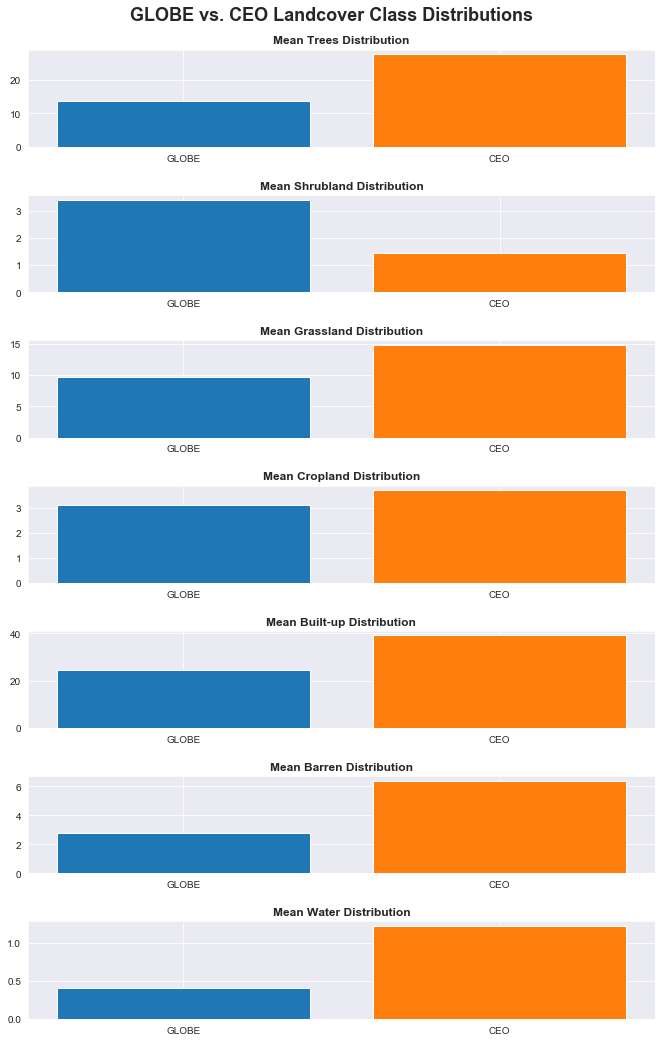

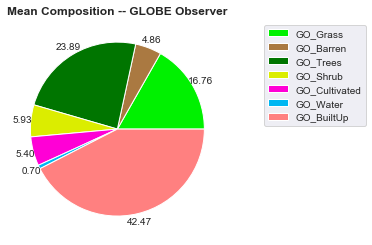

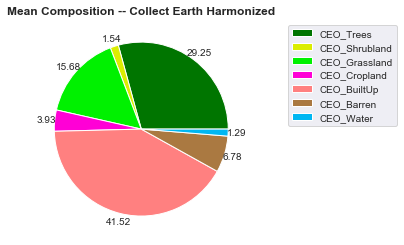

In [14]:
dataset_comparison_plot(
    joined_df,
    ["GLOBE", "CEO"],
    harmonization_table,
    harmonization_table_lookup,
    directory=output_directory,
)
aoi_composition_plot(
    joined_df,
    "GLOBE Observer",
    globe_legend.keys(),
    globe_legend.values(),
    directory=output_directory,
)
aoi_composition_plot(
    joined_df,
    "Collect Earth Harmonized",
    harmonized_ceo_legend.keys(),
    harmonized_ceo_legend.values(),
    directory=output_directory,
)

# Data Download

In [15]:
joined_df.to_csv(f"{output_directory}/PSU-GO-{start_date} to {end_date}-CEO.csv")